In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

## Data Load

In [2]:
train_16 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'],dtype={"parcelid": int})

In [3]:
prop_16 = pd.read_csv('properties_2016.csv',dtype={"parcelid": int})

/home/hskimim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df1 = pd.merge(train_16,prop_16,on='parcelid', how ='left')

In [5]:
train_df = train_df1.copy()

train_17 = pd.read_csv('train_2017.csv',parse_dates=['transactiondate'],dtype={"parcelid": int})

prop_17 = pd.read_csv('properties_2017.csv',dtype={"parcelid": int})

train_df2 = pd.merge(train_17,prop_17,on='parcelid', how ='left',dtype={"parcelid": int})

train_df = pd.concat([train_df1,train_df2])

17년 데이터는 생략한 상태

## Outer feature data analysis

- 'bathroomcnt'
- 'calculatedbathnbr'
- 'threequarterbathnbr'
- 'fullbathcnt'
- 'bedroomcnt'
- 'roomcnt’
- 'garagecarcnt'
- 'garagetotalsqft'

In [34]:
inner_feature= [
    '화장실 갯수',
    '화장실 갯수',
      '집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)',
    '풀옵션 화장실의 갯수',
    '침실 갯수',
     '주거지에있는 총 객실 수',
    '차고 갯수',
    '차고 평방(크기)',
    '에이컨 아이디'
]

In [33]:
inner_feature_col=[
  'bathroomcnt',
'calculatedbathnbr',
'threequarterbathnbr',
'fullbathcnt',
'bedroomcnt',
    'roomcnt',
'garagecarcnt',
'garagetotalsqft',
'airconditioningtypeid'
]

In [35]:
inner_df = pd.DataFrame(columns=['name','feature'])
inner_df.name = inner_feature_col
inner_df.feature = inner_feature
inner_df

,name,feature
0,bathroomcnt,화장실 갯수
1,calculatedbathnbr,화장실 갯수
2,threequarterbathnbr,집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
3,fullbathcnt,풀옵션 화장실의 갯수
4,bedroomcnt,침실 갯수
5,roomcnt,주거지에있는 총 객실 수
6,garagecarcnt,차고 갯수
7,garagetotalsqft,차고 평방(크기)
8,airconditioningtypeid,에이컨 아이디


## Data type

In [36]:
print(train_df[inner_feature_col].dtypes,end='\n\n'),
print('Number of outer_feature_col:  {}'.format(len(inner_feature_col)))

bathroomcnt              float64
calculatedbathnbr        float64
threequarterbathnbr      float64
fullbathcnt              float64
bedroomcnt               float64
roomcnt                  float64
garagecarcnt             float64
garagetotalsqft          float64
airconditioningtypeid    float64
dtype: object

Number of outer_feature_col:  9


## Missing value

In [37]:
inner_missing = train_df[inner_feature_col].isnull().sum().reset_index()
inner_missing.columns = ['columns','missing_count']
inner_missing.sort_values(by='missing_count',inplace=True)
inner_missing['missing_ratio'] = inner_missing.missing_count / len(train_df)
inner_missing

,columns,missing_count,missing_ratio
0,bathroomcnt,0,0.000000
4,bedroomcnt,0,0.000000
5,roomcnt,0,0.000000
1,calculatedbathnbr,1182,0.013093
3,fullbathcnt,1182,0.013093
6,garagecarcnt,60338,0.668380
7,garagetotalsqft,60338,0.668380
8,airconditioningtypeid,61494,0.681185
2,threequarterbathnbr,78266,0.866973


## Individual columns' feature analysis

### dividing float data type columns
- continous type
- discrete type

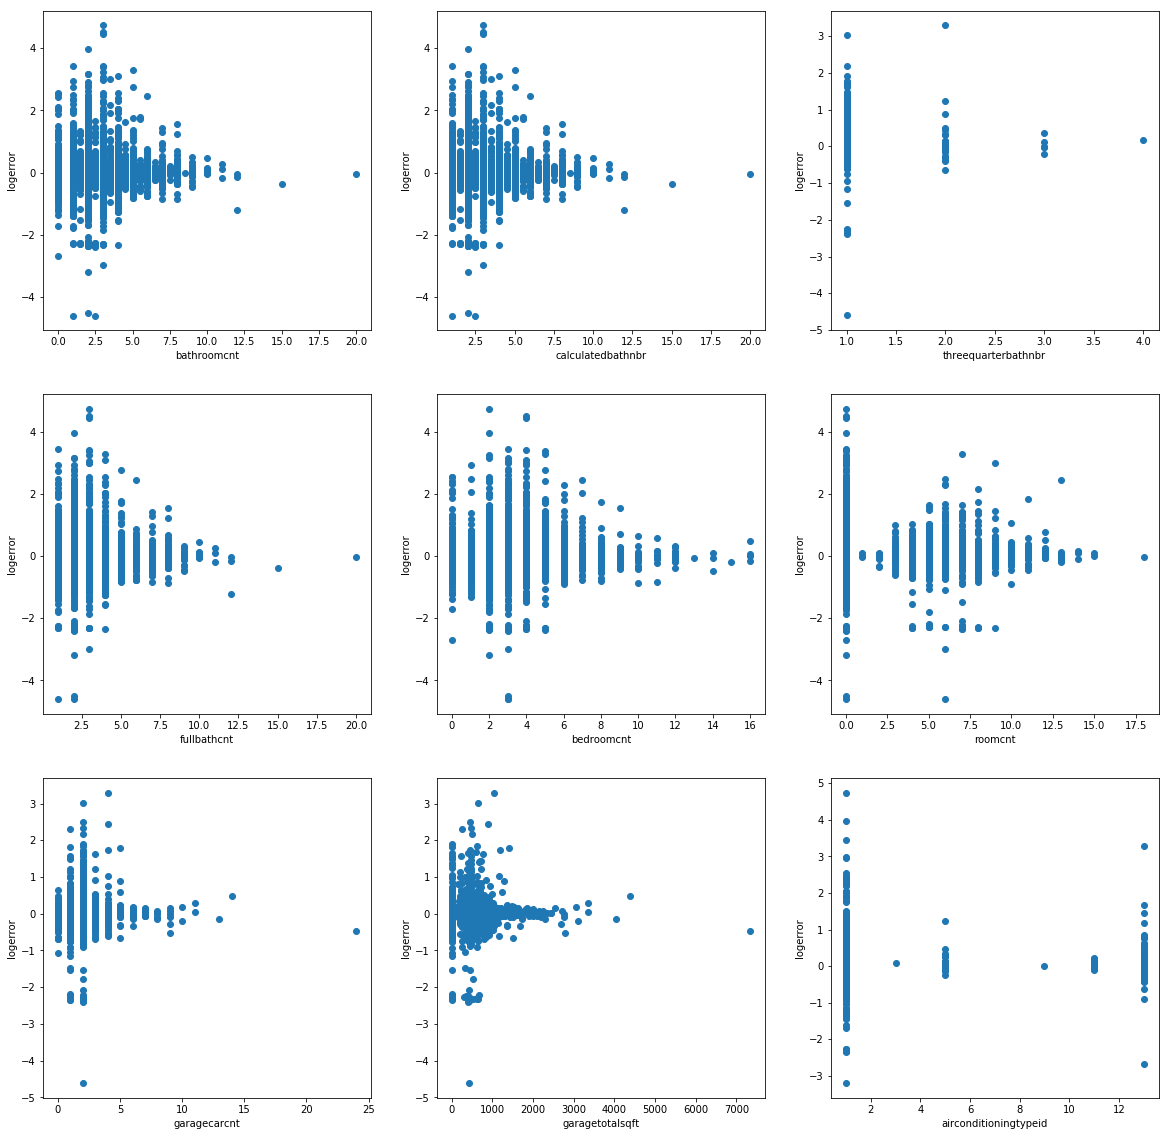

In [38]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_feature_col):
    plt.subplot(3,3,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

전체적인 column들이 discrete하다고 판단되어 모두 countplot으로 그려보겠습니다.

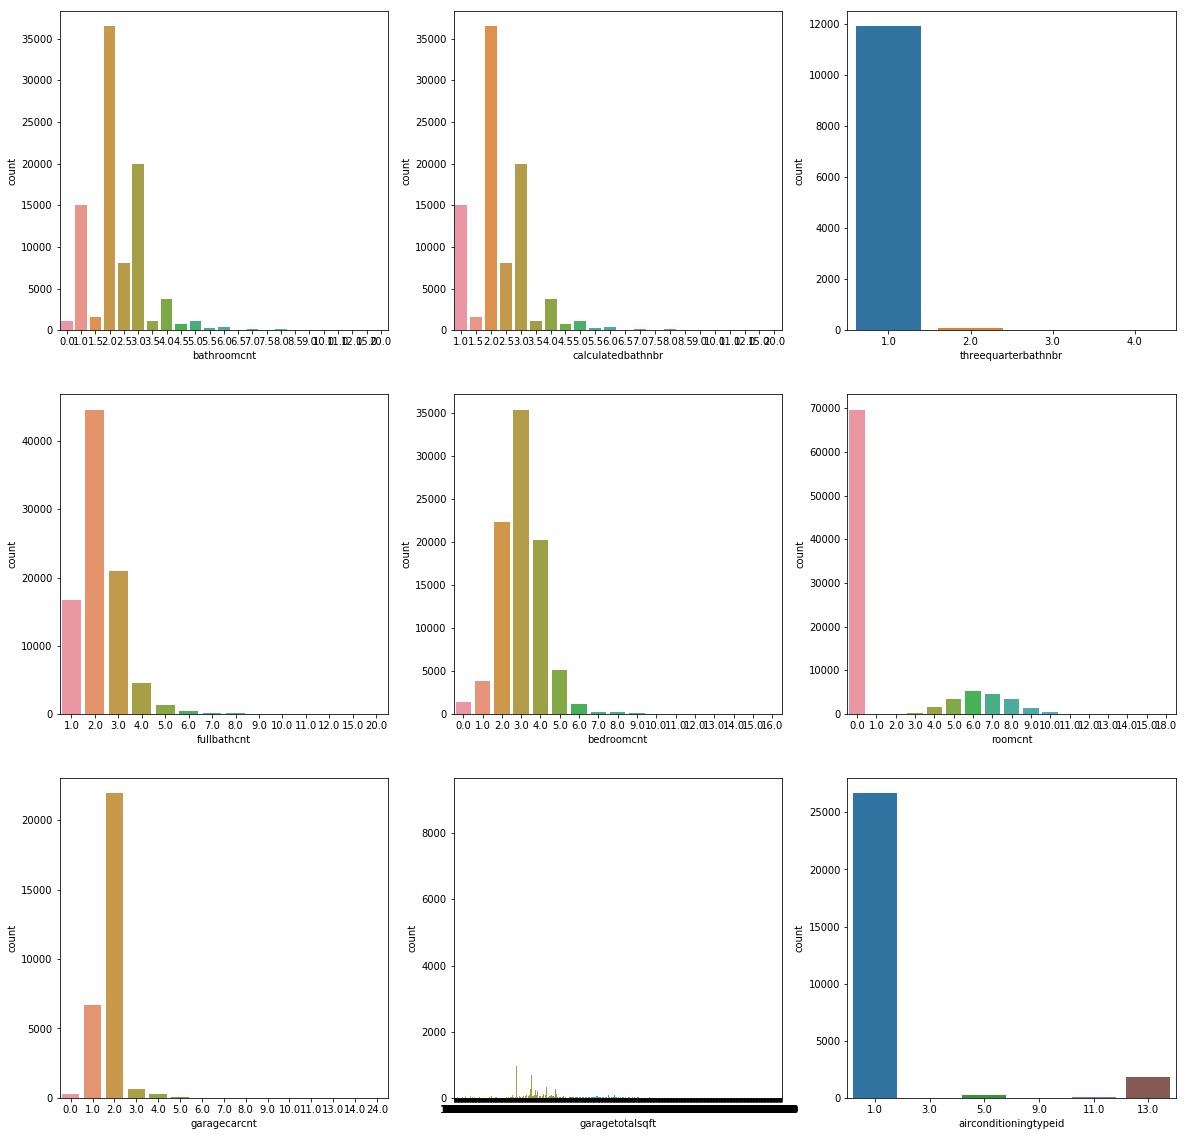

In [41]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_feature_col):
    plt.subplot(3,3,idx+1)
    sns.countplot(train_df[col],data=train_df)
    plt.xlabel(col)
    plt.ylabel('count')
plt.show()

In [44]:
train_df.garagetotalsqft.value_counts().head()

0.0      9209
400.0     970
441.0     796
360.0     735
462.0     728
Name: garagetotalsqft, dtype: int64

## Comments

- 집 안의 요소들을 대표하는 inner_feature들의 distribution들은 자료형이 모두 float형이지만, 그 분포가 이산형이다.
- garagetotlasqft(차고의 평방미터 크기) 컬럼은 이산형이지만 분포도가 심하며, 0(차고가 없다)의 값의 비중이 매우 높다.
- bathrooncnt , calculatedvathnbr 이 두 컬럼의 의미하는 바가 같고 분포도가 유사하여 cleaning작업 때 고려해야 한다.